In [8]:
# 2019.3.21 晚上 8点开始  --------朱宏伟
import numpy as np 
import xlrd
import xlwt
import sys 
import math
import random 
from route_produce import route_produce
from pheromone_update_local import pheromone_update_local
from length_get import length_get
from pheromone_update_global import pheromone_update_global
import pandas as pd
import matplotlib.pyplot as plt
sys.version

'3.6.0 |Anaconda custom (64-bit)| (default, Dec 23 2016, 11:57:41) [MSC v.1900 64 bit (AMD64)]'

In [9]:
#加载测试集
citys = xlrd.open_workbook('eil51.xls')#打开xls
sheet = citys.sheets()[0] #读取第几个sheet
citys_number = sheet.nrows # 读出xls的行数，即城市数
print(citys_number)

51


In [10]:
# 计算城市之间的距离
distance_between_city = np.zeros((citys_number,citys_number))
for i in range(citys_number):
    for j in range(citys_number):
        coordinatei = sheet.row_values(i)
        coordinatej = sheet.row_values(j)
        coord1 = [coordinatei[m]-coordinatej[m] for m in range(len(coordinatei))] #坐标相减
        coord2 = [coord1[i]**2 for i in range(len(coordinatei))]#每项平方
        coord3 = sum(coord2) # 相加
        coord4 = math.sqrt(coord3)
        if (i ==j):
            distance_between_city[i,j]==0
        else:
            distance_between_city[i,j] = coord4
#print(distance_between_city)

[[  0.          12.36931688  19.20937271 ...,  26.40075756  24.20743687
   13.89244399]
 [ 12.36931688   0.          15.29705854 ...,  21.02379604  13.89244399
   21.02379604]
 [ 19.20937271  15.29705854   0.         ...,  36.22154055  27.29468813
   32.55764119]
 ..., 
 [ 26.40075756  21.02379604  36.22154055 ...,   0.          12.04159458
   21.63330765]
 [ 24.20743687  13.89244399  27.29468813 ...,  12.04159458   0.
   26.17250466]
 [ 13.89244399  21.02379604  32.55764119 ...,  21.63330765  26.17250466
    0.        ]]


In [11]:
#计算初始信息素
citys_random = random.sample(range(0,citys_number),citys_number)
city1 = citys_random[0]
tabu = []
tabu.append(city1)
ALLOW_index=[]
for i in range(citys_number-1):
    ALLOW_citys = [item for item in citys_random if item not in tabu]#判断哪些城市还可以走，也可以分开写成一个for循环，一个if判断语句,
############################################
######返回可以走的城市的引索
#     for j in range(len(ALLOW_citys)):
#         ALLOW_index.append(citys_random.index(ALLOW_citys[j]))
############################################
#P=np.zeros([len(ALLOW_citys),1])#转移概率
#for k in range(len(ALLOW_citys)):
#   P[k]=1/distance_between_city[tabu[len(tabu)-1],ALLOW_citys[k]]
############################################
#上下两种写法都可以生成转移概率，但是上面的P是个列向量，而下面的P是个list，向量是无法append的，如果需要append，可以用np.append
    P=[]
    #计算转移概率
    for k in range(len(ALLOW_citys)):
        p=1/distance_between_city[tabu[len(tabu)-1],ALLOW_citys[k]]
        P.append(p)
    MAXindex = P.index(max(P))# 最近城市的引索
    tabu.append(ALLOW_citys[MAXindex])
#print(tabu)
length = 0
for j in range(len(tabu)-1):
    length = length+distance_between_city[tabu[j],tabu[j+1]]
length = length + distance_between_city[tabu[len(tabu)-1],tabu[0]]

#初始信息素的值
tao_set = 1/(length*citys_number)

In [12]:
#对信息素矩阵进行赋值
tau_Matrix_ACS = np.zeros([citys_number,citys_number])
for i in range(citys_number):
    for j in range(citys_number):
        if i ==j:
            tau_Matrix_ACS[i,j]=0
        else:
            tau_Matrix_ACS[i,j]=tao_set
#print(tau_Matrix_ACS)       

In [13]:
#蚁群算法的参数
ant_number = 5
alpha_ACS= 1
beta_ACS= 4
rho_global_ACS = 0.3                  
rho_local_ACS = 0.1
Eta= 1/distance_between_city
#print(Eta)
iter_max = 50
q0 = 0.8
length_best_ACS=0
min_PL_ACS=[]
min_route=[]


C:\acconda\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: divide by zero encountered in true_divide


In [14]:
##整个蚁群算法的框架

for ite in range(iter_max):
    route_all_ants,tau_Matrix_ACS = route_produce(ant_number,citys_number,distance_between_city,tau_Matrix_ACS,alpha_ACS,beta_ACS,Eta,q0,rho_local_ACS,tao_set)
    length_best_ACS,min_route = length_get(length_best_ACS,ite,route_all_ants,ant_number,citys_number,distance_between_city,min_PL_ACS,min_route)
    min_PL_ACS.append(length_best_ACS)
    ########如果想加入3-opt在下面写程序
    #写在这里
    ##########
    tau_Matrix_ACS = pheromone_update_global(tau_Matrix_ACS,rho_global_ACS,citys_number,min_route,length_best_ACS)
print('最短距离：',length_best_ACS)
print('最优路径：',min_route)


最短距离： 517.751265131
最优路径： [12 40 18 41 43 14 44 32  9 19 34 35  2 27 30  7 25  6 22 47 26 50 45 11 46
  3 16 36  4 37 10 31  0 21  1 15 49  8 48 29 33 20 28 38 17 13 24 23 42  5
 39]


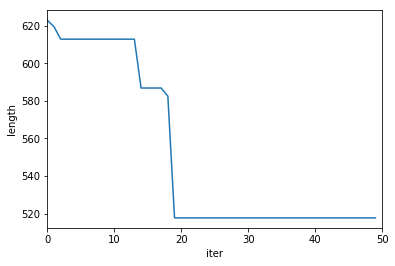

In [15]:
####下面是迭代曲线的绘制
x = [x for x in range(iter_max)]#x轴
plt.xlim(0.0, iter_max) # 限制x轴值的范围
y = min_PL_ACS # y轴
plt.xlabel('iter')
plt.ylabel('length')
plt.plot(x,y) #画图
#plt.savefig('./test.jpg')#保存生成的图片，注意每次保存的名字需要修改，或者是写一个自动化命名的程序
plt.show()

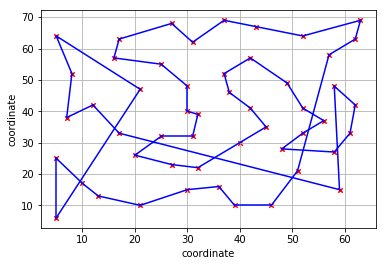

In [16]:
######蚁群地图的绘制,使用panda可以更好的读取表格，txt的一些数据
citys = pd.read_excel('eil51.xls',header = None)
citys_array = citys.values
#print(citys_array)
x = []
y = []
for i in range(citys_number):
    a = citys_array[i,0]
    x.append(a)
for j in range(citys_number):
    b = citys_array[j,1]
    y.append(b)
plt.grid()#网格线
plt.xlabel('coordinate')
plt.ylabel('coordinate')
plt.scatter(x, y, marker = 'x',color = 'red', s = 20)
for i in range(citys_number-1):
    x = [citys_array[min_route[i],0],citys_array[min_route[i+1],0]]
    y = [citys_array[min_route[i],1],citys_array[min_route[i+1],1]]
    plt.plot(x,y,color = 'b')
x = [citys_array[min_route[0],0],citys_array[min_route[citys_number-1],0]]
y = [citys_array[min_route[0],1],citys_array[min_route[citys_number-1],1]]
#print(y)
plt.plot(x,y,color = 'b')
plt.show()